# Test IIR coefficients determination

In [1]:
import numpy as np
import json
import matplotlib.pyplot as plt

from pathlib import Path
from scipy.signal import lfilter, lfilter_zi
from scipy.optimize import least_squares, minimize, Bounds
from cryoscope_scripts import load_cryoscope_data
from IIR import (
    step,
    inverse_model_IIR,
    residuals_inverse_IIR,
    multi_exponential_IIR,
    residuals_multi_exponential,
)

from numpy import convolve

from qibocal.protocols.two_qubit_interaction.cryoscope import (
    _fit,
    _plot,
    CryoscopeData,
    CryoscopeType,
)

[Qibo 0.2.12|INFO|2024-12-15 20:00:50]: Loading platform dummy
[Qibo 0.2.12|INFO|2024-12-15 20:00:50]: Loading platform dummy


In [2]:
data_path = Path.cwd().parent / "cryo_material" / "long_acquisition" / "data" / "cryoscope-0"
data_json = data_path / "data.json"

with open(data_json, "rb") as file:
    data = json.load(file)

flux_pulse_amplitude = data["\"flux_pulse_amplitude\""]
cryoscope_data = load_cryoscope_data(data_path / "data.npz",0.5)

In [3]:
cryoscope_results = _fit(cryoscope_data)

In [4]:
t = np.arange(0,99,1)
start = 10
ideal_signal = step(t, start)

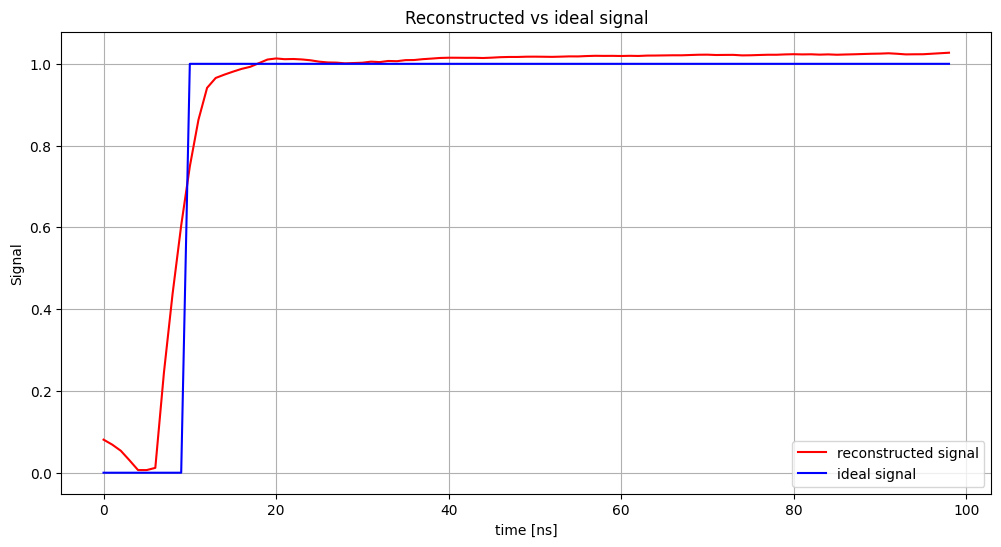

In [5]:
plt.figure(figsize=(12, 6))
plt.plot(cryoscope_results.step_response["D1"], color="red", label="reconstructed signal")
plt.plot(ideal_signal, color="blue", label="ideal signal")
plt.xlabel("time [ns]")
plt.ylabel("Signal")
plt.title("Reconstructed vs ideal signal")
plt.legend()
plt.grid()
plt.show()

**Testing parameters conversion for a single fit**

In [6]:
# single filter application
initial_guess = [1, 1, 1]
step_response = cryoscope_results.step_response["D1"]
result = least_squares(
    residuals_inverse_IIR, initial_guess, args=(t, start, step_response)
)
print(result)

     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [-1.545e-23 -2.230e-21 ...  1.295e-02  1.417e-02]
           x: [ 1.013e+00  1.948e-01 -2.614e-01]
        cost: 0.018716405722484165
         jac: [[ 1.526e-23 -4.073e-21 -5.913e-23]
               [ 2.202e-21 -5.290e-19 -8.533e-21]
               ...
               [-1.000e+00  0.000e+00 -0.000e+00]
               [-1.001e+00  0.000e+00 -0.000e+00]]
        grad: [-1.989e-10  2.120e-08 -1.175e-07]
  optimality: 1.174800214659346e-07
 active_mask: [ 0.000e+00  0.000e+00  0.000e+00]
        nfev: 13
        njev: 11


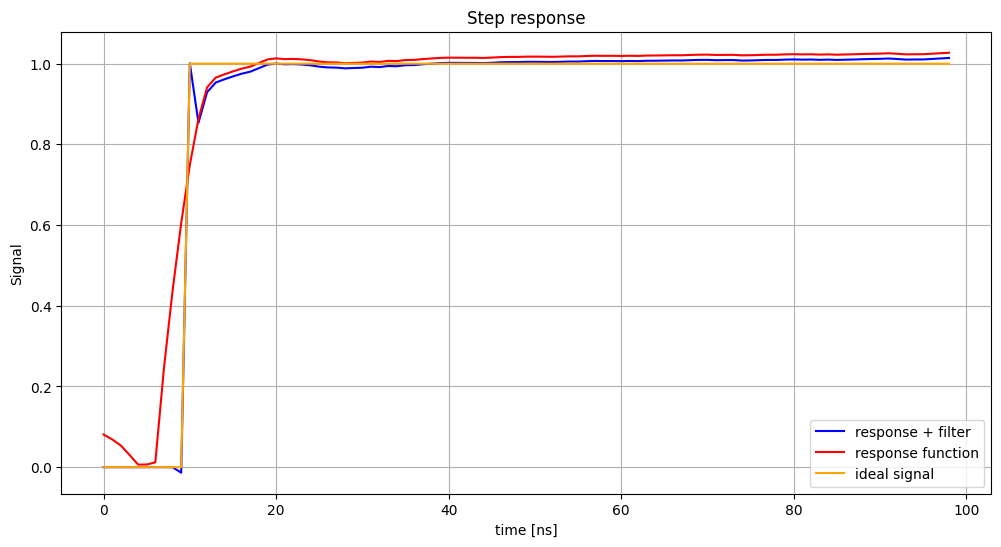

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(
    t,
    inverse_model_IIR(result.x, t, start, step_response),
    color="blue",
    label="response + filter",
)
plt.plot(step_response, color="red", label="response function")
plt.plot(t, step(t, start), color="orange", label="ideal signal")
plt.xlabel("time [ns]")
plt.ylabel("Signal")
plt.title("Step response")
plt.legend()
plt.grid()
plt.show()

In [8]:
print(result.x)

[ 1.01281825  0.19478486 -0.26135589]


In [9]:
def single_exp_params(params, sampling_rate):
    g, tau, A = params
    alpha = 1 - np.exp(-1/(sampling_rate*tau*(1+A)))
    k = A/((1+A)*(1-alpha)) if A < 0 else A/(1+A-alpha)
    b0 = 1 - k + k*alpha
    b1 = - (1-k)*(1-alpha)
    a0 = 1
    a1 = -(1-alpha)

    a = np.array([a0, a1])
    b = np.array([b0, b1])
    return a, b

In [10]:
a, b = single_exp_params(result.x, 1)

**Test without computing zi**

In [11]:
filtered_response = lfilter(b, a, step_response)

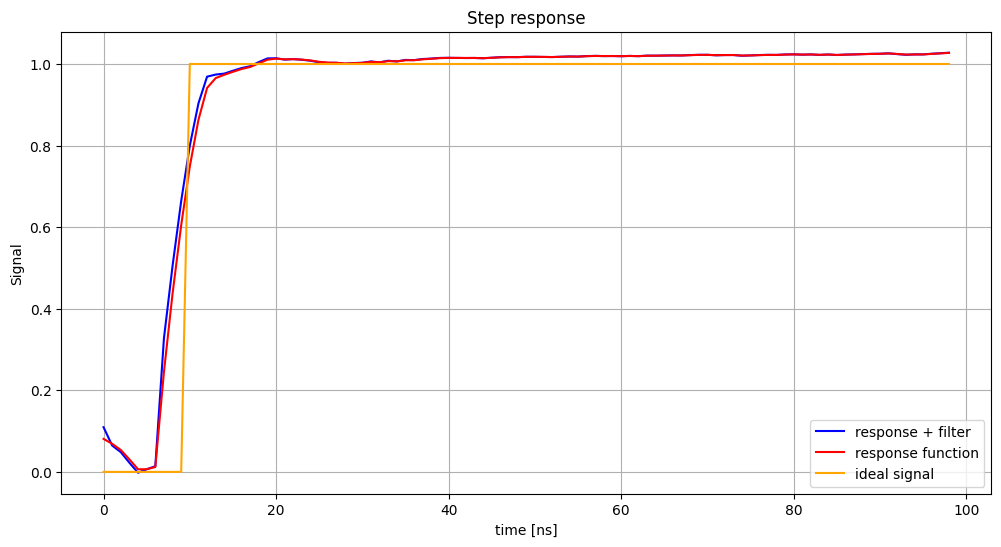

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(
    filtered_response,
    color="blue",
    label="response + filter",
)
plt.plot(step_response, color="red", label="response function")
plt.plot(t, step(t, start), color="orange", label="ideal signal")
plt.xlabel("time [ns]")
plt.ylabel("Signal")
plt.title("Step response")
plt.legend()
plt.grid()
plt.show()

**Test computing zi**

In [13]:
zi = lfilter_zi(b,a)*step_response[0]
filtered_response, _ = lfilter(b, a, step_response, zi=zi)

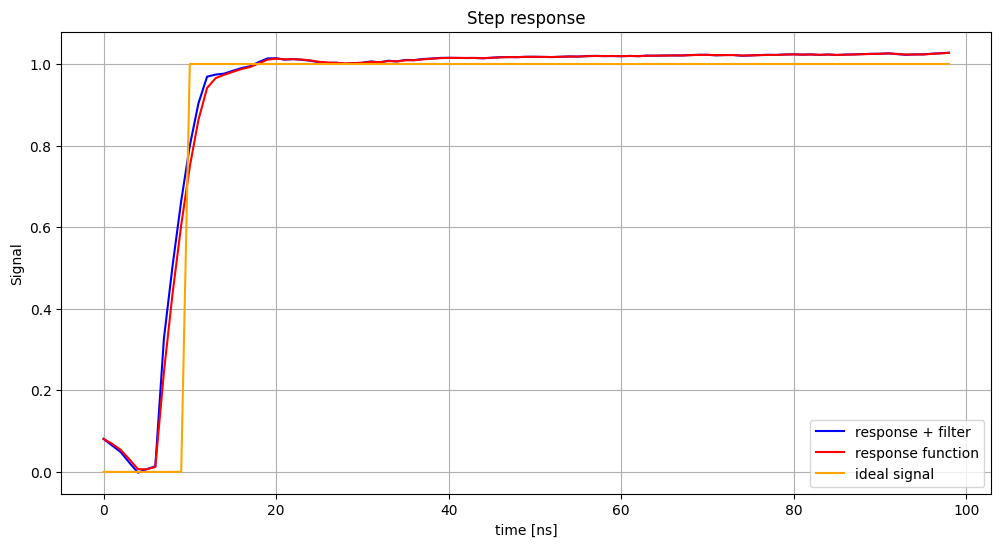

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(
    filtered_response,
    color="blue",
    label="response + filter",
)
plt.plot(step_response, color="red", label="response function")
plt.plot(t, step(t, start), color="orange", label="ideal signal")
plt.xlabel("time [ns]")
plt.ylabel("Signal")
plt.title("Step response")
plt.legend()
plt.grid()
plt.show()

**Code for filter application iteration**

In [15]:
init_guess = [1, 1, 1]
results = []
responses = []

for i in range(5):
    result = least_squares(
        residuals_inverse_IIR, initial_guess, args=(t, start, step_response)
    )
    results.append(result)
    step_response = inverse_model_IIR(result.x, t, start, step_response)
    responses.append(step_response)

/home/elisa/Desktop/Qibo/Qibocal/cryoscope/IIR.py:22: RuntimeWarning: overflow encountered in exp
  return data / (g * (1 + A * np.exp(-(t - start) / tau)))


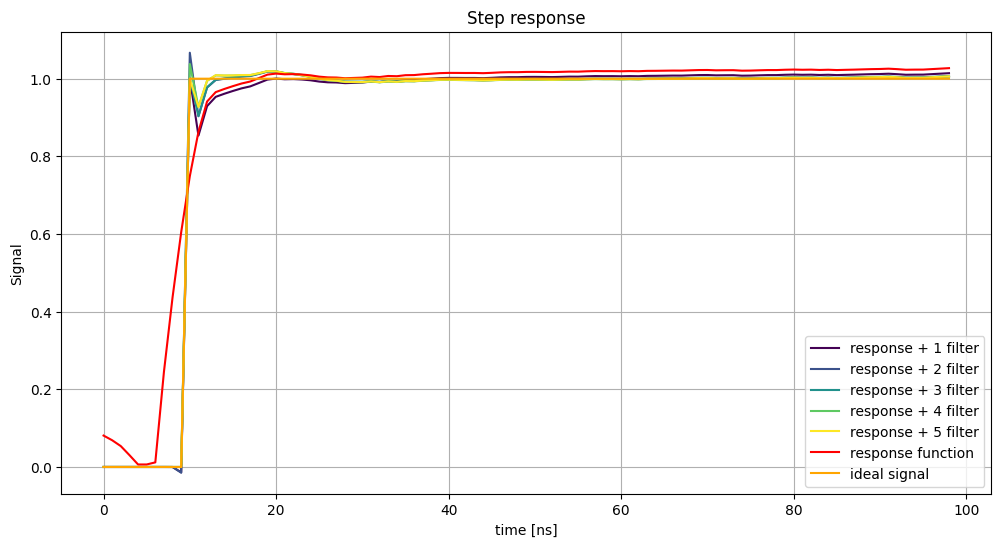

In [16]:
step_response = cryoscope_results.step_response["D1"]
colors = plt.cm.viridis(np.linspace(0, 1, len(responses)))

plt.figure(figsize=(12, 6))

for i, resp in enumerate(responses):
    plt.plot(t, resp, color=colors[i], label=f"response + {i+1} filter")
plt.plot(step_response, color="red", label="response function")
plt.plot(t, step(t, start), color="orange", label="ideal signal")
plt.xlabel("time [ns]")
plt.ylabel("Signal")
plt.title("Step response")
plt.legend()
plt.grid()
plt.show()

In [17]:
b_total = [1]
a_total = [1]

for result in results:
    params = result.x  # Extract g, tau, A
    a, b = single_exp_params(params, 1)
    b_total = convolve(b_total, b)  # Convolve numerator coefficients
    a_total = convolve(a_total, a)

print(a_total)
print(b_total)

[ 1.00000000e+00 -1.57699895e+00  6.10518825e-01 -5.83585670e-04
  0.00000000e+00  0.00000000e+00]
[ 1.51131582 -2.80700337  1.57607997 -0.24745614  0.          0.        ]


In [18]:
zi = lfilter_zi(b_total, a_total) * responses[4][0]
filtered_response, _ = lfilter(b_total, a_total, step_response, zi=zi)

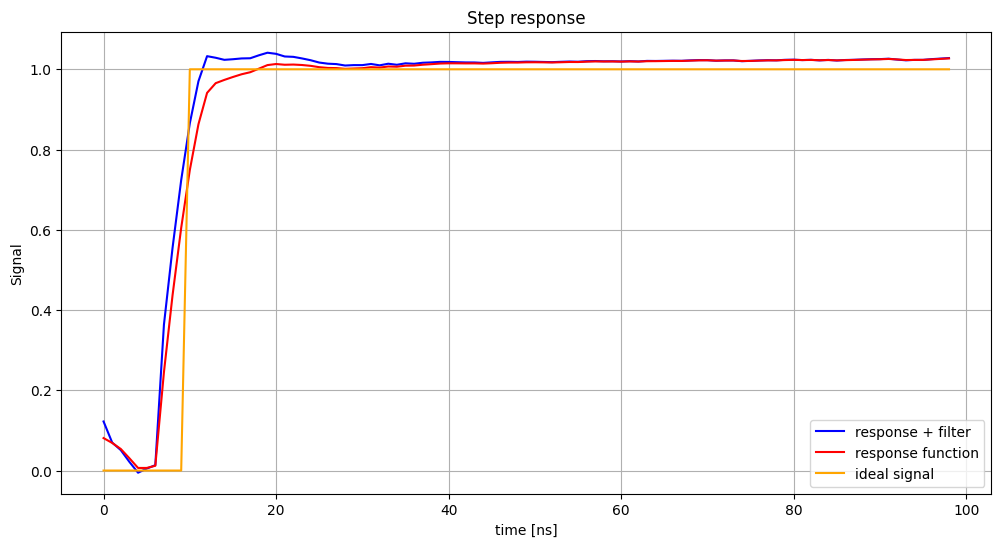

In [19]:
plt.figure(figsize=(12, 6))
plt.plot(
    filtered_response,
    color="blue",
    label="response + filter",
)
plt.plot(step_response, color="red", label="response function")
plt.plot(t, step(t, start), color="orange", label="ideal signal")
plt.xlabel("time [ns]")
plt.ylabel("Signal")
plt.title("Step response")
plt.legend()
plt.grid()
plt.show()

**Testing optimization on multi-exponential filter**